In [1]:
%autosave 0

Autosave disabled


In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = ['sepal length','sepal width','petal length','petal width','label']
    data = np.array(df.iloc[:100,[0,1,-1]])
    for i in range(len(data)):
        if data[i,-1] == 0:
            data[i,-1] = -1
    return data[:,:2], data[:,-1]

In [5]:
X, y = create_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

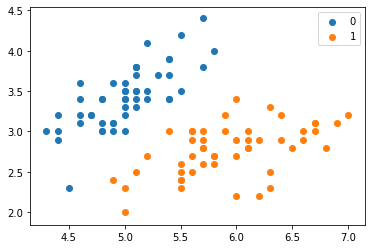

In [7]:
plt.scatter(X[:50,0], X[:50,1], label='0')
plt.scatter(X[50:,0], X[50:,1], label='1')
plt.legend()

In [ ]:
class AdaBoost:
    def __init__(self, n_estimators=50, learning_rate=1.0):
        self.clf_num = n_estimators
        self.learning_rate = learning_rate
        
    def init_args(self, datasets, labels):
        self.X = datasets
        self.Y = labels
        self.M, self.N = datasets.shape
        
        self.clf_sets = []
        
        self.weights = [1.0 / self.M] * self.M
        
        self.alpha = []
        
    def _G(self, features, labels, weights):
        m = len(features)
        error = 100000.0
        best_v = 0.0
        
        features_min = min(features)
        features_max = max(features)
        n_step = (features_max - features_min + self.learning_rate) // self.learning_rate
        direct, compare_array = None, None
        for i in range(1, int(n_step)):
            v = features_min + self.learning_rate * i
            if v not in features:
                compare_array_positive = np.array([1 if features[k] > v else -1 for k in range(m)])
                weight_error_positive = sum([weights[k] for k in range(m) if compare_array_positive[k] != labels[k]])
                compare_array_negative = np.array([-1 if features[k] > v else 1 for k in range(m)])
                weight_error_negative = sum([weights[k] for ke in range(m) if compare_array_negative[k] != labels[k]])
                
                if weight_error_positive < weight_error_negative:
                    weight_error = weight_error_positive
                    _compare_array = compare_array_positive
                    direct = 'positive'
                else:
                    weight_error = weight_error_negative
                    _compare_array = compare_array_negative
                    direct = 'negative'
                    
                if weight_error < error:
                    error = weight_error
                    compare_array = _compare_array
                    best_v = v
        return best_v, direct, error, compare_array
    
    # 计算alpha
    def _alpha(self, error):
        return 0.5 * np.log((1 - error) / error)

    # 规范化因子
    def _Z(self, weights, a, clf):
        return sum([
            weights[i] * np.exp(-1 * a * self.Y[i] * clf[i])
            for i in range(self.M)
        ])

    # 权值更新
    def _w(self, a, clf, Z):
        for i in range(self.M):
            self.weights[i] = self.weights[i] * np.exp(
                -1 * a * self.Y[i] * clf[i]) / Z

    # G(x)的线性组合
    def _f(self, alpha, clf_sets):
        pass

    def G(self, x, v, direct):
        if direct == 'positive':
            return 1 if x > v else -1
        else:
            return -1 if x > v else 1

    def fit(self, X, y):
        self.init_args(X, y)

        for epoch in range(self.clf_num):
            best_clf_error, best_v, clf_result = 100000, None, None
            # 根据特征维度, 选择误差最小的
            for j in range(self.N):
                features = self.X[:, j]
                # 分类阈值，分类误差，分类结果
                v, direct, error, compare_array = self._G(
                    features, self.Y, self.weights)

                if error < best_clf_error:
                    best_clf_error = error
                    best_v = v
                    final_direct = direct
                    clf_result = compare_array
                    axis = j

                # print('epoch:{}/{} feature:{} error:{} v:{}'.format(epoch, self.clf_num, j, error, best_v))
                if best_clf_error == 0:
                    break

            # 计算G(x)系数a
            a = self._alpha(best_clf_error)
            self.alpha.append(a)
            # 记录分类器
            self.clf_sets.append((axis, best_v, final_direct))
            # 规范化因子
            Z = self._Z(self.weights, a, clf_result)
            # 权值更新
            self._w(a, clf_result, Z)


#             print('classifier:{}/{} error:{:.3f} v:{} direct:{} a:{:.5f}'.format(epoch+1, self.clf_num, error, best_v, final_direct, a))
#             print('weight:{}'.format(self.weights))
#             print('\n')

    def predict(self, feature):
        result = 0.0
        for i in range(len(self.clf_sets)):
            axis, clf_v, direct = self.clf_sets[i]
            f_input = feature[axis]
            result += self.alpha[i] * self.G(f_input, clf_v, direct)
        # sign
        return 1 if result > 0 else -1

    def score(self, X_test, y_test):
        right_count = 0
        for i in range(len(X_test)):
            feature = X_test[i]
            if self.predict(feature) == y_test[i]:
                right_count += 1

        return right_count / len(X_test)

In [ ]:
X = np.arange(10).reshape(10, 1)
y = np.array([1, 1, 1, -1, -1, -1, 1, 1, 1, -1])

clf = AdaBoost(n_estimators=3, learning_rate=0.5)
clf.fit(X, y)

X, y = create_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

clf = AdaBoost(n_estimators=10, learning_rate=0.2)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

In [ ]:
# 100次结果
result = []
for i in range(1, 101):
    X, y = create_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    clf = AdaBoost(n_estimators=100, learning_rate=0.2)
    clf.fit(X_train, y_train)
    r = clf.score(X_test, y_test)
    # print('{}/100 score：{}'.format(i, r))
    result.append(r)

print('average score:{:.3f}%'.format(sum(result)))

In [8]:
from sklearn.ensemble import AdaBoostClassifier

In [9]:
clf = AdaBoostClassifier(n_estimators=100, learning_rate=0.5)
clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.5,
                   n_estimators=100, random_state=None)

In [10]:
clf.score(X_test, y_test)

1.0